In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('axes', axisbelow=True)
from matplotlib import gridspec
import seaborn as sns
import numpy as np
import torch
import library.functions.misc_helper_functions as misc_helpers
from library.functions import model_parameters
import library.data.data_helper_functions as data_helpers

import os, time


In [2]:
model_folder = "/work1/s174505/Thesis/Models/"
cnn_model_id = "13936780_0"

In [3]:
labels_X = [
    'Velocity', 'AccB1Y', 'AccB1Z', 'AccCR1Y', 'AccCR1Z', 'AccB2Y', 'AccB2Z', 
    'AccCR2Y', 'AccCR2Z', 'AccB3Y', 'AccB3Z', 'AccCR3Y', 'AccCR3Z', 'AccB4Y', 
    'AccB4Z', 'AccCR4Y', 'AccCR4Z', 'AccB5Y', 'AccB5Z', 'AccCR5Y', 'AccCR5Z', 
    'AccB6Y', 'AccB6Z', 'AccCR6Y', 'AccCR6Z', 'AccB7Y', 'AccB7Z', 'AccCR7Y', 
    'AccCR7Z', 'AccB8Y', 'AccB8Z', 'AccCR8Y', 'AccCR8Z', 
    'AccCSAY', 'AccCSAZ', 'AccCSBY', 'AccCSBZ', 
    'Curvature' 
]
labels_y = [
    'Lateral left D1', 'Lateral right D1', 'Vertical left D1', 'Vertical right D1', 
    'Lateral left D2', 'Lateral right D2', 'Vertical left D2', 'Vertical right D2', 
    'Lateral left D3', 'Lateral right D3', 'Vertical left D3', 'Vertical right D3', 
]

In [4]:
positions, training_errors, validation_errors_raw, test_errors, training_true_values, validation_true_values, test_true_values = \
    torch.load("/work1/s174505/Thesis/Errors/Model_errors_"+cnn_model_id+".pty")
validation_errors = torch.stack([validation_errors_raw[cv_index][0] for cv_index in validation_errors_raw])
val_true_values = torch.stack([validation_true_values[cv_index][0] for cv_index in validation_true_values])
test_errors = torch.stack(list(test_errors.values()))
test_true_values = torch.stack(list(test_true_values.values()))
test_predictions = test_true_values + test_errors
test_predictions_agg = test_predictions.mean(0)
test_errors_agg = test_predictions_agg - test_true_values[0]
test_true_values = test_true_values[0]
test_pos = positions[0]["test"]

test_prediction_difference = test_predictions.max(0)[0] - test_predictions.min(0)[0]
test_prediction_std = test_predictions.std(0)

In [5]:
print(test_errors_agg.abs().mean((0,2)).round(decimals=2))
print(test_errors_agg.abs().mean().round(decimals=2))

tensor([0.1400, 0.1300, 0.2700, 0.2800, 0.2000, 0.1800, 0.3000, 0.3100, 0.3500,
        0.3300, 0.6300, 0.6400])
tensor(0.3100)


In [6]:
rel_error=(test_errors_agg/test_true_values).abs()
rel_error[test_true_values.abs()<1e-3] = torch.nan
print(rel_error.nanmean((0,2)))

tensor([0.6774, 0.6366, 1.4136, 1.3703, 0.7787, 0.6889, 1.6559, 1.5796, 0.7826,
        0.6898, 1.4944, 1.5226])


In [7]:
200/(27.98/60)

428.8777698355969

In [8]:
MAPE = rel_error.nanmean().numpy()
MAE = test_errors_agg.abs().mean().numpy()
RMSE = (test_errors_agg**2).mean().sqrt().numpy()
TIC = (RMSE / ( (test_true_values**2).mean().sqrt() + (test_predictions_agg**2).mean().sqrt())).numpy()
PCC_ERROR = np.corrcoef(test_true_values.numpy().flatten(), test_errors_agg.numpy().flatten())[0,1]
PCC_PRED = np.corrcoef(test_true_values.numpy().flatten(), test_predictions_agg.numpy().flatten())[0,1]

print("MAPE:     ", 100*MAPE, "%")
print("MAE:      ", MAE)
print("RMSE:     ", RMSE)
print("TIC      :", TIC)
print("PCC error:", PCC_ERROR)
print("PCC pred: ", PCC_PRED)

MAPE:      110.72285175323486 %
MAE:       0.3141842
RMSE:      0.52219224
TIC      : 0.19020243
PCC error: -0.5223607015531958
PCC pred:  0.9371959320788319


In [9]:
gamma = np.logspace(np.log2(0.95),np.log2(1.1),25,base=2)
gamma_MAE = np.zeros_like(gamma)
bias = test_errors.mean()
for i in range(len(gamma)):
    gamma_MAE[i] = (gamma[i]*test_predictions_agg - bias - test_true_values).abs().mean()
with_bias = pd.DataFrame({"gamma" : gamma, "MAE" : gamma_MAE}).assign(bias=lambda _: True)
bias = 0
for i in range(len(gamma)):
    gamma_MAE[i] = (gamma[i]*test_predictions_agg - bias - test_true_values).abs().mean()
without_bias = pd.DataFrame({"gamma" : gamma, "MAE" : gamma_MAE}).assign(bias=lambda _: False)


In [10]:
pd.concat((with_bias, without_bias)).sort_values("MAE").head(5)

,gamma,MAE,bias
18,1.060414,0.309633,False
18,1.060414,0.309662,True
17,1.053956,0.309671,False
19,1.066911,0.309702,False
17,1.053956,0.309704,True


In [11]:
print( (test_errors_agg.abs().mean().round(decimals=2) / torch.Tensor([test_true_values[:,i,:].abs().max() for i in range(12)])).round(decimals=2) )

tensor([0.0400, 0.0400, 0.1000, 0.1000, 0.0400, 0.0400, 0.0700, 0.0700, 0.0200,
        0.0200, 0.0300, 0.0300])


In [12]:
print(torch.Tensor([test_errors_agg[:,i,:].abs().quantile(0.95).round(decimals=2) for i in range(12)]))
print(test_errors_agg.abs().quantile(0.95).round(decimals=2))

tensor([0.4200, 0.3900, 0.7100, 0.7400, 0.5700, 0.5000, 0.7700, 0.8200, 0.9200,
        0.8600, 1.7700, 1.7500])
tensor(0.9800)


In [13]:
print(torch.Tensor([test_errors_agg[:,i,:].abs().max().round(decimals=2) for i in range(12)]))
print(test_errors_agg.abs().max().round(decimals=2))

tensor([2.5400, 2.6200, 2.2300, 2.5600, 3.5500, 3.4900, 2.2800, 2.6300, 7.3300,
        7.6100, 6.5800, 6.1900])
tensor(7.6100)


In [14]:
test_errors_agg[:,:,100].max()

tensor(0.5596)

In [15]:
max_errors = test_errors_agg.abs().max(1)[0]

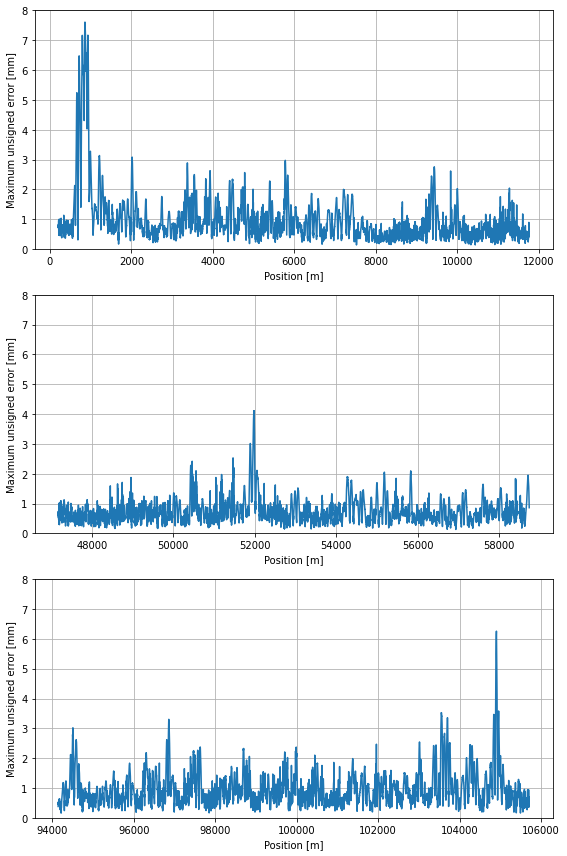

In [16]:
fig, axes = plt.subplots(3,1,figsize=(8,12))
start_idx, end_idx = 0, max_errors.shape[-1]
for segment in range(3):
    ax = axes[segment]

    ax.plot(test_pos[segment][start_idx:end_idx], max_errors[segment, start_idx:end_idx])
    ax.set_xlabel("Position [m]")
    ax.set_ylabel("Maximum unsigned error [mm]")
    ax.grid()
    ax.set_ylim([0, 8])

fig.tight_layout()

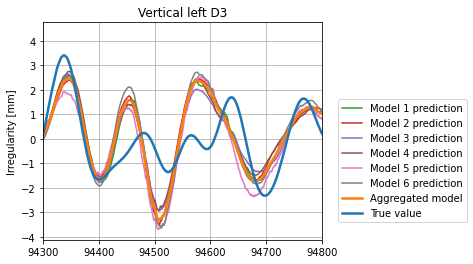

In [17]:
fig, ax = plt.subplots(1,1,figsize=(5,4), sharex=True, sharey=True)
start_idx = 0
end_idx = 2000
segment = 2
geometry_idx = 10
for i in range(6):
    ax.plot(test_pos[segment][start_idx:end_idx], test_predictions[i, segment, geometry_idx, start_idx:end_idx], 
        label=f"Model {i+1} prediction", color=plt.cm.tab10(2+i))
ax.plot(test_pos[segment][start_idx:end_idx], test_predictions_agg[segment, geometry_idx, start_idx:end_idx], 
    label="Aggregated model", color=plt.cm.tab10(1), linewidth=2.5)
ax.plot(test_pos[segment][start_idx:end_idx], test_true_values[segment, geometry_idx, start_idx:end_idx], 
    color=plt.cm.tab10(0), label="True value", linewidth=2.5, ls="-")

ax.set_xlim([test_pos[segment][start_idx], test_pos[segment][end_idx]])
ax.set_xlim([94300, 94800])
ax.grid()
ax.set_title(labels_y[geometry_idx])
ax.set_ylabel("Irregularity [mm]")

fig.legend(bbox_to_anchor=(0.93,0.63), loc="upper left")

fig.savefig("plots/Model predictions.pdf", format="pdf", bbox_inches="tight")

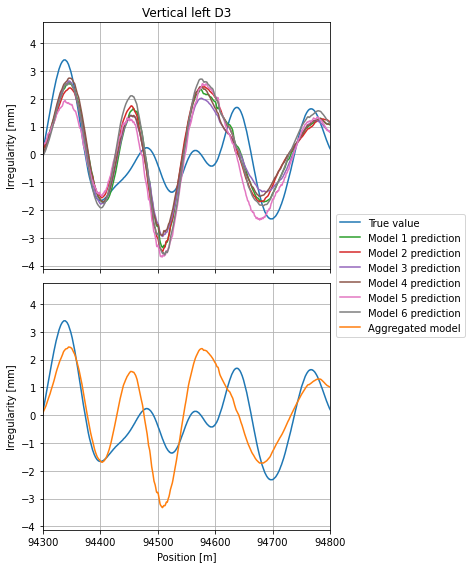

In [18]:
fig, axes = plt.subplots(2,1,figsize=(5,8), sharex=True, sharey=True)
start_idx = 0
end_idx = 2000
segment = 2
geometry_idx = 10
ax: plt.Axes = axes[0]
ax.plot(test_pos[segment][start_idx:end_idx], test_true_values[segment, geometry_idx, start_idx:end_idx], label="True value")
for i in range(6):
    ax.plot(test_pos[segment][start_idx:end_idx], test_predictions[i, segment, geometry_idx, start_idx:end_idx], 
        label=f"Model {i+1} prediction", color=plt.cm.tab10(2+i))

# ax.set_xlim([test_pos[segment][start_idx], test_pos[segment][end_idx]])
ax.set_xlim([94300, 94800])
ax.grid()
ax.set_title(labels_y[geometry_idx])
ax.set_ylabel("Irregularity [mm]")

ax = axes[1]

ax.plot(test_pos[segment][start_idx:end_idx], test_true_values[segment, geometry_idx, start_idx:end_idx])
ax.plot(test_pos[segment][start_idx:end_idx], test_predictions_agg[segment, geometry_idx, start_idx:end_idx], label="Aggregated model", color=plt.cm.tab10(1))
ax.set_xlabel("Position [m]")
ax.set_ylabel("Irregularity [mm]")

handles0, labels0 = axes[0].get_legend_handles_labels()
handles1, labels1 = axes[1].get_legend_handles_labels()

fig.legend(handles0+handles1, labels0+labels1, bbox_to_anchor=(0.93,0.63), loc="upper left")
ax.grid()

fig.tight_layout()

fig.savefig("plots/Model variation.pdf", format="pdf", bbox_inches="tight")

In [19]:
(test_prediction_std[test_true_values.abs() > 1e-8]/(test_true_values[test_true_values.abs() > 1e-8])).max()

tensor(58.4520)

In [20]:
test_true_values.shape

torch.Size([3, 12, 23132])

In [21]:
test_predictions.shape

torch.Size([6, 3, 12, 23132])

In [22]:
validation_errors.shape

torch.Size([6, 1, 12, 9192])

In [23]:
alpha = 0.05
if os.path.exists("/work1/s174505/Thesis/Errors/cv_plus.pty"):
    (cv_plus_lower, cv_plus_upper) = torch.load("/work1/s174505/Thesis/Errors/cv_plus.pty")

else:
    cv_plus_lower   = torch.zeros_like(test_true_values)
    cv_plus_upper   = torch.zeros_like(test_true_values)

    # CV plus method
    # for segment in range(3):
    #     print("Segment", segment)
    #     for feature in range(12):
    #         print("Feature", feature)
    for idx in range(test_predictions.shape[-1]):
        if idx%1000 == 0:
            print(idx)
        cv_plus_lower[:, :, idx] = torch.from_numpy(np.quantile(
            test_predictions[:, :, :, idx][:,:,:,None] - validation_errors[:, 0, :, :][:,None,:,:].abs(), alpha, axis=(0,3)))
        cv_plus_upper[:, :, idx] = torch.from_numpy(np.quantile(
            test_predictions[:, :, :, idx][:,:,:,None] + validation_errors[:, 0, :, :][:,None,:,:].abs(), 1-alpha, axis=(0,3)))
    torch.save((cv_plus_lower, cv_plus_upper), "/work1/s174505/Thesis/Errors/cv_plus.pty")

In [24]:
t = time.time()
cv_minmax_lower = test_predictions.min(0).values - validation_errors.abs().quantile(1-alpha)
cv_minmax_upper = test_predictions.max(0).values + validation_errors.abs().quantile(1-alpha)
print(time.time() - t)

0.11776041984558105


In [25]:
gamma = 1.053624177483841
test_predictions_new = gamma*(test_true_values + test_errors)
validation_errors_new = (1-gamma)*val_true_values + gamma*validation_errors.squeeze()

In [26]:
t = time.time()
cv_minmax_lower_new = test_predictions_new.min(0).values - validation_errors_new.abs().quantile(1-alpha)
cv_minmax_upper_new = test_predictions_new.max(0).values + validation_errors_new.abs().quantile(1-alpha)
print(time.time() - t)

0.12157893180847168


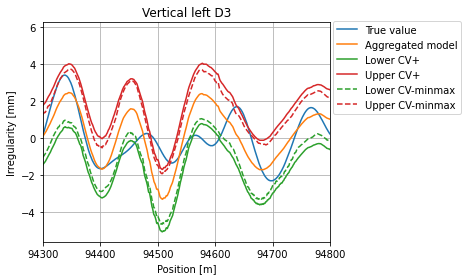

In [27]:
fig, ax = plt.subplots(1,1,figsize=(5,4))

start_idx = 0
end_idx = 2000
segment = 2
geometry_idx = 10

ax.plot(test_pos[segment][start_idx:end_idx], test_true_values[segment, geometry_idx, start_idx:end_idx], 
    label="True value", color=plt.cm.tab10(0))
ax.plot(test_pos[segment][start_idx:end_idx], test_predictions_agg[segment, geometry_idx, start_idx:end_idx], 
    label="Aggregated model", color=plt.cm.tab10(1))
ax.plot(test_pos[segment][start_idx:end_idx], cv_plus_lower[segment, geometry_idx, start_idx:end_idx], 
    label="Lower CV+", color=plt.cm.tab10(2))
ax.plot(test_pos[segment][start_idx:end_idx], cv_plus_upper[segment, geometry_idx, start_idx:end_idx], 
    label="Upper CV+", color=plt.cm.tab10(3))
ax.plot(test_pos[segment][start_idx:end_idx], cv_minmax_lower[segment, geometry_idx, start_idx:end_idx], 
    label="Lower CV-minmax", linestyle="--", color=plt.cm.tab10(2))
ax.plot(test_pos[segment][start_idx:end_idx], cv_minmax_upper[segment, geometry_idx, start_idx:end_idx], 
    label="Upper CV-minmax", linestyle="--", color=plt.cm.tab10(3))
ax.set_xlabel("Position [m]")
ax.set_ylabel("Irregularity [mm]")
ax.set_xlim([94300, 94800])
ax.set_title(labels_y[geometry_idx])
fig.legend(bbox_to_anchor=(0.92,0.93), loc="upper left")
fig.tight_layout()
ax.grid()

fig.savefig("plots/Conformal predictions CNN.pdf", bbox_inches="tight")

In [28]:
within_plus = ((test_true_values >= cv_plus_lower) & (test_true_values <= cv_plus_upper)).to(dtype=torch.float32)
within_minmax = ((test_true_values >= cv_minmax_lower) & (test_true_values <= cv_minmax_upper)).to(dtype=torch.float32)
within_minmax_new = ((test_true_values >= cv_minmax_lower_new) & (test_true_values <= cv_minmax_upper_new)).to(dtype=torch.float32)
width_plus = (cv_plus_upper - cv_plus_lower).to(dtype=torch.float32)
width_minmax = (cv_minmax_upper - cv_minmax_lower).to(dtype=torch.float32)
width_minmax_new = (cv_minmax_upper_new - cv_minmax_lower_new).to(dtype=torch.float32)

In [29]:
print("Within CV+:              {:.2f} %".format(100*float(within_plus.mean())))
print("Within CV-minmax:        {:.2f} %".format(100*float(within_minmax.mean())))
print("Within CV-minmax new:        {:.2f} %".format(100*float(within_minmax_new.mean())))
print("Average width CV+:       {:.2f}".format(float(width_plus.mean())))
print("Average width CV-minmax: {:.2f}".format(float(width_minmax.mean())))
print("Average width CV-minmax new: {:.2f}".format(float(width_minmax_new.mean())))
print("Maximum width CV+:       {:.2f}".format(float(width_plus.max())))
print("Maximum width CV-minmax: {:.2f}".format(float(width_minmax.max())))
print("Maximum width CV-minmax new: {:.2f}".format(float(width_minmax_new.max())))

Within CV+:              95.76 %
Within CV-minmax:        97.18 %
Within CV-minmax new:        98.16 %
Average width CV+:       1.78
Average width CV-minmax: 2.33
Average width CV-minmax new: 2.64
Maximum width CV+:       4.54
Maximum width CV-minmax: 5.25
Maximum width CV-minmax new: 5.72


In [30]:
test_pos[0][-1]*3

tensor(35304.)

In [31]:
35.30/(12*60)*3600

176.5

In [32]:
550*8/60

73.33333333333333

In [33]:
35.30/0.12054443359375*3600

1054217.0734177215

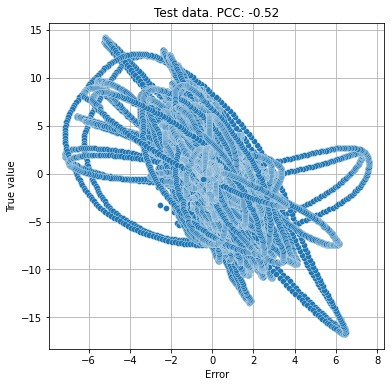

In [34]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(test_errors_agg.flatten(), test_true_values.flatten(), edgecolors="w", linewidths=0.3)
ax.set_xlabel("Error")
ax.set_ylabel("True value")
ax.set_title("Test data. PCC: {:.2f}".format(np.corrcoef(test_true_values.numpy().flatten(), test_errors_agg.numpy().flatten())[0,1]))
ax.grid()

In [35]:
gamma = 1.053624177483841
test_errors_agg_new = (gamma-1)*test_true_values + gamma*test_errors_agg

In [36]:
test_errors_agg_new.abs().mean()

tensor(0.3097)

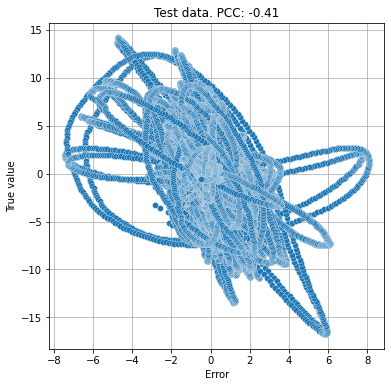

In [37]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(test_errors_agg_new.flatten(), test_true_values.flatten(), edgecolors="w", linewidths=0.3)
ax.set_xlabel("Error")
ax.set_ylabel("True value")
ax.set_title("Test data. PCC: {:.2f}".format(np.corrcoef(test_true_values.numpy().flatten(), test_errors_agg_new.numpy().flatten())[0,1]))
ax.grid()

In [38]:
rel_error_new=(test_errors_agg_new/test_true_values).abs()
rel_error_new[test_true_values.abs()<1e-3] = torch.nan
print(rel_error_new.nanmean((0,2)))

tensor([0.6959, 0.6538, 1.4513, 1.4054, 0.8078, 0.7135, 1.7213, 1.6394, 0.8163,
        0.7218, 1.5615, 1.5898])


In [39]:
MAPE = rel_error.nanmean().numpy()
MAE = test_errors_agg.abs().mean().numpy()
RMSE = (test_errors_agg**2).mean().sqrt().numpy()
TIC = (RMSE / ( (test_true_values**2).mean().sqrt() + (test_predictions_agg**2).mean().sqrt())).numpy()
PCC_ERROR = np.corrcoef(test_true_values.numpy().flatten(), test_errors_agg.numpy().flatten())[0,1]
PCC_PRED = np.corrcoef(test_true_values.numpy().flatten(), test_predictions_agg.numpy().flatten())[0,1]

print("MAPE:     ", 100*MAPE, "%")
print("MAE:      ", MAE)
print("RMSE:     ", RMSE)
print("TIC      :", TIC)
print("PCC error:", PCC_ERROR)
print("PCC pred: ", PCC_PRED)

MAPE:      110.72285175323486 %
MAE:       0.3141842
RMSE:      0.52219224
TIC      : 0.19020243
PCC error: -0.5223607015531958
PCC pred:  0.9371959320788319


In [40]:
MAPE = rel_error_new.nanmean().numpy()
MAE = test_errors_agg_new.abs().mean().numpy()
RMSE = (test_errors_agg_new**2).mean().sqrt().numpy()
TIC = (RMSE / ( (test_true_values**2).mean().sqrt() + (test_predictions_agg**2).mean().sqrt())).numpy()
PCC_ERROR = np.corrcoef(test_true_values.numpy().flatten(), test_errors_agg_new.numpy().flatten())[0,1]
PCC_PRED = np.corrcoef(test_true_values.numpy().flatten(), test_predictions_agg.numpy().flatten())[0,1]

print("MAPE:     ", 100*MAPE, "%")
print("MAE:      ", MAE)
print("RMSE:     ", RMSE)
print("TIC      :", TIC)
print("PCC error:", PCC_ERROR)
print("PCC pred: ", PCC_PRED)

MAPE:      114.78407382965088 %
MAE:       0.30967587
RMSE:      0.51346433
TIC      : 0.18702339
PCC error: -0.40629689441093314
PCC pred:  0.9371959320788319


In [41]:
print(test_errors_agg_new.abs().mean())
print(test_errors_agg_new.abs().quantile(0.95))
print(test_errors_agg_new.abs().max())

tensor(0.3097)
tensor(0.9563)
tensor(8.0748)
